In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

In [24]:
# 데이터 전처리

data = pd.read_csv('../../dataset/processed/hair_salon_data.csv')
X = data.drop(columns='noshow')
y = data['noshow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)


In [25]:
# 추정기 학습

rfc = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': [5, 10, 'sqrt'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10, 15],
                         'max_features': [5, 10, 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

📌 최적 threshold: 0.25
🔍 Recall: 0.5556
🔍 Precision: 0.2874
🔍 F1 Score: 0.3788
🔢 Confusion Matrix:
[[284  62]
 [ 20  25]]


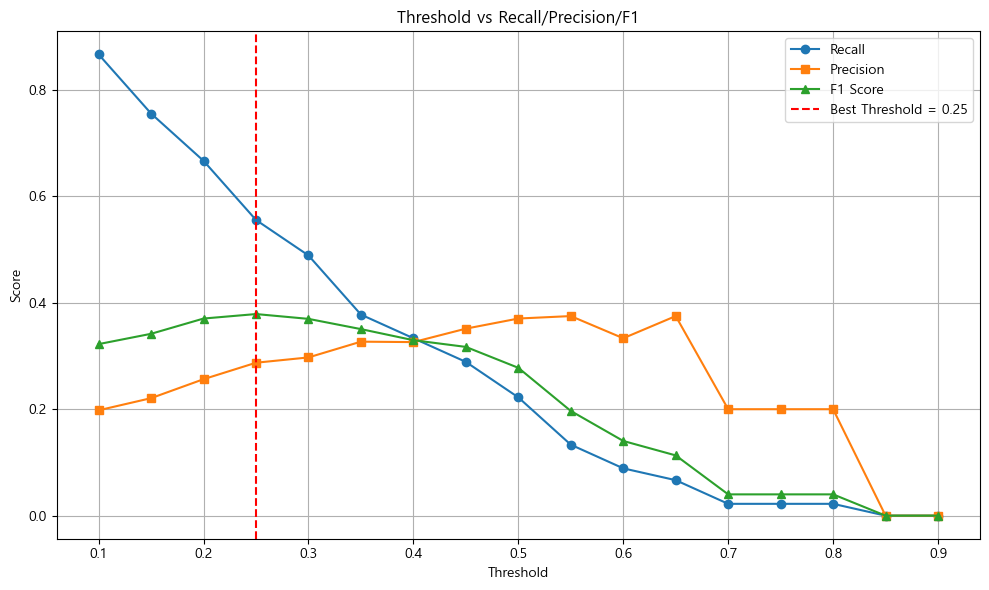

In [26]:
# 최적의 임계값 찾기

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, confusion_matrix
)

best_model = grid_search.best_estimator_

# 테스트 데이터 확률 예측
y_proba = best_model.predict_proba(X_test_encoded)[:, 1]

# 여러 임계값에서 지표 측정
thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s, accuracies = [], [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# 최적 임계값 (F1 기준)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print(f"📌 최적 threshold: {best_threshold:.2f}")
print(f"🔍 Recall: {recalls[best_idx]:.4f}")
print(f"🔍 Precision: {precisions[best_idx]:.4f}")
print(f"🔍 F1 Score: {f1s[best_idx]:.4f}")

# confusion matrix 출력
y_final = (y_proba >= best_threshold).astype(int)
print("🔢 Confusion Matrix:")
print(confusion_matrix(y_test, y_final))

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='s')
plt.plot(thresholds, f1s, label="F1 Score", marker='^')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Recall/Precision/F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()